# ViT — Multiclass Classification on GZ10 (Enhanced)

This notebook trains a Vision Transformer on **MultimodalUniverse/gz10** with:
- Demo vs Full training toggle
- Progress bars
- Confusion matrix + metric curves
- Best checkpoint save & reload
- Mixed precision (AMP) when CUDA is available
- Robust validation split creation
- Batch-aware transforms for Hugging Face Datasets


## 0) Install dependencies (once per environment)

In [44]:
# %pip install -U datasets timm torch torchvision transformers accelerate scikit-learn tqdm matplotlib numpy --quiet

## 1) Imports & configuration

In [45]:
import os, math, json, time, numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEMO = False
EPOCHS = 3 if DEMO else 100
BATCH_TRAIN = 32 if DEMO else 64
BATCH_VAL = 64 if DEMO else 128

USE_AMP = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE, '| AMP:', USE_AMP, '| Epochs:', EPOCHS)


Device: cuda | AMP: True | Epochs: 100


## 2) Load GZ10 and create a validation split (if missing)
We use the `datasets` library. The dataset has images under `rgb_image` and labels under `gz10_label`.

In [46]:
ds = load_dataset('MultimodalUniverse/gz10')
print(ds)

if 'validation' not in ds:
    from datasets import DatasetDict
    labels = np.array(ds['train']['gz10_label'])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
    (train_idx, val_idx), = sss.split(np.zeros(len(labels)), labels)
    ds = DatasetDict({
        'train': ds['train'].select(train_idx.tolist()),
        'validation': ds['train'].select(val_idx.tolist()),
        **({'test': ds['test']} if 'test' in ds else {})
    })
print(ds)


DatasetDict({
    train: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale'],
        num_rows: 17736
    })
})
DatasetDict({
    train: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale'],
        num_rows: 15962
    })
    validation: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale'],
        num_rows: 1774
    })
})


## 3) Transforms and dataset wrappers (batch-aware)

In [47]:
IMG_SIZE = 224
from torchvision import transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def make_transform(split):
    tfm = train_tf if split == 'train' else val_tf
    def _apply(batch):
        imgs = [tfm(img) for img in batch['rgb_image']]
        labels = [int(y) for y in batch['gz10_label']]
        return {'pixel_values': imgs, 'label': labels}
    return _apply

for sp in ['train', 'validation', 'test']:
    if sp in ds:
        ds[sp] = ds[sp].with_transform(make_transform(sp))


## 4) DataLoaders

In [48]:
from torch.utils.data import DataLoader
train_loader = DataLoader(ds['train'], batch_size=BATCH_TRAIN, shuffle=True)
val_loader = DataLoader(ds['validation'], batch_size=BATCH_VAL, shuffle=False)
print('Batches | train:', len(train_loader), 'val:', len(val_loader))


Batches | train: 250 val: 14


## 5) Model, optimizer, scheduler, and AMP scaler

In [49]:
NUM_CLASSES = 10
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

ckpt_dir = Path('checkpoints'); ckpt_dir.mkdir(exist_ok=True)
best_path = ckpt_dir / 'best_vit_gz10.pth'
best_acc = -1.0


/tmp/ipykernel_3794604/3395360783.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


## 6) Training & validation loops with progress bars

In [50]:
train_losses = []
val_accs = []

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [train]')
    running = 0.0
    for batch in pbar:
        xb = batch['pixel_values'].to(DEVICE)
        yb = batch['label'].to(DEVICE)

        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
            loss = loss_fn(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running += loss.item()
        pbar.set_postfix({'loss': f'{running/((pbar.n or 1)):.4f}'})

    train_loss = running / max(1, len(train_loader))
    train_losses.append(train_loss)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [val]'):
            xb = batch['pixel_values'].to(DEVICE)
            yb = batch['label']
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits = model(xb)
            pr = logits.argmax(1).cpu()
            y_true += yb.numpy().tolist()
            y_pred += pr.numpy().tolist()

    from sklearn.metrics import accuracy_score
    acc = accuracy_score(y_true, y_pred)
    val_accs.append(acc)
    print(f'Epoch {epoch+1}: train_loss={train_loss:.4f} | val_acc={acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        torch.save({'model_state': model.state_dict(), 'acc': best_acc, 'epoch': epoch+1}, best_path)
        print(f'Saved new best checkpoint: val_acc={best_acc:.4f} -> {best_path}')

    sched.step()


Epoch 1/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


Epoch 1: train_loss=2.2474 | val_acc=0.2576
Saved new best checkpoint: val_acc=0.2576 -> checkpoints/best_vit_gz10.pth


Epoch 2/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


Epoch 2: train_loss=1.6872 | val_acc=0.4391
Saved new best checkpoint: val_acc=0.4391 -> checkpoints/best_vit_gz10.pth


Epoch 3/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 3: train_loss=1.3814 | val_acc=0.4899
Saved new best checkpoint: val_acc=0.4899 -> checkpoints/best_vit_gz10.pth


Epoch 4/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch 4: train_loss=1.2667 | val_acc=0.5338
Saved new best checkpoint: val_acc=0.5338 -> checkpoints/best_vit_gz10.pth


Epoch 5/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 5: train_loss=1.1908 | val_acc=0.5761
Saved new best checkpoint: val_acc=0.5761 -> checkpoints/best_vit_gz10.pth


Epoch 6/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 6: train_loss=1.1310 | val_acc=0.6048
Saved new best checkpoint: val_acc=0.6048 -> checkpoints/best_vit_gz10.pth


Epoch 7/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


Epoch 7: train_loss=1.0624 | val_acc=0.6364
Saved new best checkpoint: val_acc=0.6364 -> checkpoints/best_vit_gz10.pth


Epoch 8/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch 8: train_loss=1.0171 | val_acc=0.6144


Epoch 9/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 9: train_loss=0.9538 | val_acc=0.6657
Saved new best checkpoint: val_acc=0.6657 -> checkpoints/best_vit_gz10.pth


Epoch 10/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Epoch 10: train_loss=0.9309 | val_acc=0.6488


Epoch 11/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


Epoch 11: train_loss=0.8917 | val_acc=0.6578


Epoch 12/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 12: train_loss=0.8649 | val_acc=0.6747
Saved new best checkpoint: val_acc=0.6747 -> checkpoints/best_vit_gz10.pth


Epoch 13/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 13: train_loss=0.8495 | val_acc=0.7041
Saved new best checkpoint: val_acc=0.7041 -> checkpoints/best_vit_gz10.pth


Epoch 14/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


Epoch 14: train_loss=0.8235 | val_acc=0.6950


Epoch 15/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 15: train_loss=0.8015 | val_acc=0.6984


Epoch 16/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 16: train_loss=0.7813 | val_acc=0.6962


Epoch 17/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17/100 [val]: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


Epoch 17: train_loss=0.7571 | val_acc=0.7204
Saved new best checkpoint: val_acc=0.7204 -> checkpoints/best_vit_gz10.pth


Epoch 18/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 18: train_loss=0.7396 | val_acc=0.6973


Epoch 19/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 19: train_loss=0.7246 | val_acc=0.7142


Epoch 20/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Epoch 20: train_loss=0.7069 | val_acc=0.7108


Epoch 21/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 21/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 21/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]


Epoch 21: train_loss=0.6893 | val_acc=0.7018


Epoch 22/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 22/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 22/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Epoch 22: train_loss=0.6756 | val_acc=0.7170


Epoch 23/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 23/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 23/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 23: train_loss=0.6621 | val_acc=0.7204


Epoch 24/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 24/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 24/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 24: train_loss=0.6336 | val_acc=0.7018


Epoch 25/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 25/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 25/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]


Epoch 25: train_loss=0.6238 | val_acc=0.7300
Saved new best checkpoint: val_acc=0.7300 -> checkpoints/best_vit_gz10.pth


Epoch 26/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 26/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 26/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 26: train_loss=0.5905 | val_acc=0.7283


Epoch 27/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 27/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 27/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 27: train_loss=0.5835 | val_acc=0.7266


Epoch 28/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 28/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 28/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


Epoch 28: train_loss=0.5746 | val_acc=0.6945


Epoch 29/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 29/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 29/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


Epoch 29: train_loss=0.5517 | val_acc=0.7272


Epoch 30/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 30/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 30/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


Epoch 30: train_loss=0.5277 | val_acc=0.7176


Epoch 31/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 31/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 31/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch 31: train_loss=0.5018 | val_acc=0.7300


Epoch 32/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 32/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 32/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 32: train_loss=0.4849 | val_acc=0.7260


Epoch 33/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 33/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 33/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


Epoch 33: train_loss=0.4821 | val_acc=0.7311
Saved new best checkpoint: val_acc=0.7311 -> checkpoints/best_vit_gz10.pth


Epoch 34/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 34/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 34/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]


Epoch 34: train_loss=0.4441 | val_acc=0.7311


Epoch 35/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 35/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 35/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


Epoch 35: train_loss=0.4299 | val_acc=0.7221


Epoch 36/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 36/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 36/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Epoch 36: train_loss=0.4132 | val_acc=0.7159


Epoch 37/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 37/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 37/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]


Epoch 37: train_loss=0.3935 | val_acc=0.7204


Epoch 38/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 38/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 38/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch 38: train_loss=0.3625 | val_acc=0.7069


Epoch 39/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 39/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 39/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 39: train_loss=0.3445 | val_acc=0.7266


Epoch 40/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 40/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 40/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 40: train_loss=0.3174 | val_acc=0.7266


Epoch 41/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 41/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 41/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Epoch 41: train_loss=0.3043 | val_acc=0.7069


Epoch 42/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 42/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 42/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 42: train_loss=0.2822 | val_acc=0.7232


Epoch 43/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 43/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 43/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Epoch 43: train_loss=0.2537 | val_acc=0.7306


Epoch 44/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 44/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 44/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 44: train_loss=0.2223 | val_acc=0.7334
Saved new best checkpoint: val_acc=0.7334 -> checkpoints/best_vit_gz10.pth


Epoch 45/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 45/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 45/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Epoch 45: train_loss=0.2167 | val_acc=0.6995


Epoch 46/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 46/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 46/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch 46: train_loss=0.1949 | val_acc=0.7148


Epoch 47/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 47/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 47/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]


Epoch 47: train_loss=0.1886 | val_acc=0.7221


Epoch 48/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 48/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 48/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 48: train_loss=0.1632 | val_acc=0.7215


Epoch 49/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 49/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 49/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Epoch 49: train_loss=0.1500 | val_acc=0.7238


Epoch 50/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 50/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 50/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 50: train_loss=0.1337 | val_acc=0.7249


Epoch 51/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 51/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 51/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 51: train_loss=0.1205 | val_acc=0.7277


Epoch 52/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 52/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 52/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


Epoch 52: train_loss=0.1109 | val_acc=0.7283


Epoch 53/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 53/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 53/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 53: train_loss=0.1037 | val_acc=0.7153


Epoch 54/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 54/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 54/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


Epoch 54: train_loss=0.0859 | val_acc=0.7193


Epoch 55/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 55/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 55/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 55: train_loss=0.0810 | val_acc=0.7413
Saved new best checkpoint: val_acc=0.7413 -> checkpoints/best_vit_gz10.pth


Epoch 56/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 56/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 56/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Epoch 56: train_loss=0.0704 | val_acc=0.7187


Epoch 57/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 57/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 57/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Epoch 57: train_loss=0.0642 | val_acc=0.7148


Epoch 58/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 58/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 58/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


Epoch 58: train_loss=0.0641 | val_acc=0.7283


Epoch 59/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 59/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 59/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.00it/s]


Epoch 59: train_loss=0.0509 | val_acc=0.7227


Epoch 60/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 60/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 60/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


Epoch 60: train_loss=0.0499 | val_acc=0.7255


Epoch 61/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 61/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 61/100 [val]: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


Epoch 61: train_loss=0.0468 | val_acc=0.7294


Epoch 62/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 62/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 62/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 62: train_loss=0.0505 | val_acc=0.7368


Epoch 63/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 63/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 63/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


Epoch 63: train_loss=0.0412 | val_acc=0.7255


Epoch 64/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 64/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 64/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Epoch 64: train_loss=0.0359 | val_acc=0.7311


Epoch 65/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 65/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 65/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


Epoch 65: train_loss=0.0318 | val_acc=0.7306


Epoch 66/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 66/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 66/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Epoch 66: train_loss=0.0361 | val_acc=0.7294


Epoch 67/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 67/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 67/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 67: train_loss=0.0277 | val_acc=0.7322


Epoch 68/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 68/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 68/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 68: train_loss=0.0272 | val_acc=0.7300


Epoch 69/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 69/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 69/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 69: train_loss=0.0236 | val_acc=0.7334


Epoch 70/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 70/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 70/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 70: train_loss=0.0163 | val_acc=0.7283


Epoch 71/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 71/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 71/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


Epoch 71: train_loss=0.0157 | val_acc=0.7362


Epoch 72/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 72/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 72/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


Epoch 72: train_loss=0.0197 | val_acc=0.7283


Epoch 73/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 73/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 73/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


Epoch 73: train_loss=0.0167 | val_acc=0.7351


Epoch 74/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 74/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 74/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 74: train_loss=0.0129 | val_acc=0.7334


Epoch 75/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 75/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 75/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Epoch 75: train_loss=0.0177 | val_acc=0.7283


Epoch 76/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 76/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 76/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 76: train_loss=0.0141 | val_acc=0.7373


Epoch 77/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 77/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 77/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 77: train_loss=0.0108 | val_acc=0.7317


Epoch 78/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 78/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 78/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


Epoch 78: train_loss=0.0104 | val_acc=0.7373


Epoch 79/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 79/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 79/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 79: train_loss=0.0090 | val_acc=0.7362


Epoch 80/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 80/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 80/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


Epoch 80: train_loss=0.0093 | val_acc=0.7356


Epoch 81/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 81/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 81/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 81: train_loss=0.0083 | val_acc=0.7379


Epoch 82/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 82/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 82/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


Epoch 82: train_loss=0.0072 | val_acc=0.7396


Epoch 83/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 83/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 83/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Epoch 83: train_loss=0.0078 | val_acc=0.7373


Epoch 84/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 84/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 84/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Epoch 84: train_loss=0.0068 | val_acc=0.7362


Epoch 85/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 85/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 85/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Epoch 85: train_loss=0.0075 | val_acc=0.7396


Epoch 86/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 86/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 86/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch 86: train_loss=0.0071 | val_acc=0.7351


Epoch 87/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 87/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 87/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Epoch 87: train_loss=0.0068 | val_acc=0.7339


Epoch 88/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 88/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 88/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch 88: train_loss=0.0063 | val_acc=0.7379


Epoch 89/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 89/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 89/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 89: train_loss=0.0067 | val_acc=0.7339


Epoch 90/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 90/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 90/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]


Epoch 90: train_loss=0.0058 | val_acc=0.7379


Epoch 91/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 91/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 91/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 91: train_loss=0.0062 | val_acc=0.7373


Epoch 92/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 92/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 92/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 92: train_loss=0.0056 | val_acc=0.7334


Epoch 93/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 93/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 93/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Epoch 93: train_loss=0.0052 | val_acc=0.7339


Epoch 94/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 94/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 94/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch 94: train_loss=0.0051 | val_acc=0.7356


Epoch 95/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 95/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 95/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


Epoch 95: train_loss=0.0056 | val_acc=0.7356


Epoch 96/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 96/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 96/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Epoch 96: train_loss=0.0050 | val_acc=0.7351


Epoch 97/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 97/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 97/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


Epoch 97: train_loss=0.0048 | val_acc=0.7362


Epoch 98/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 98/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 98/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 98: train_loss=0.0048 | val_acc=0.7351


Epoch 99/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 99/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 99/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.01it/s]


Epoch 99: train_loss=0.0046 | val_acc=0.7356


Epoch 100/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 100/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/1896974608.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 100/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

Epoch 100: train_loss=0.0045 | val_acc=0.7356


## 7) Curves: training loss & validation accuracy

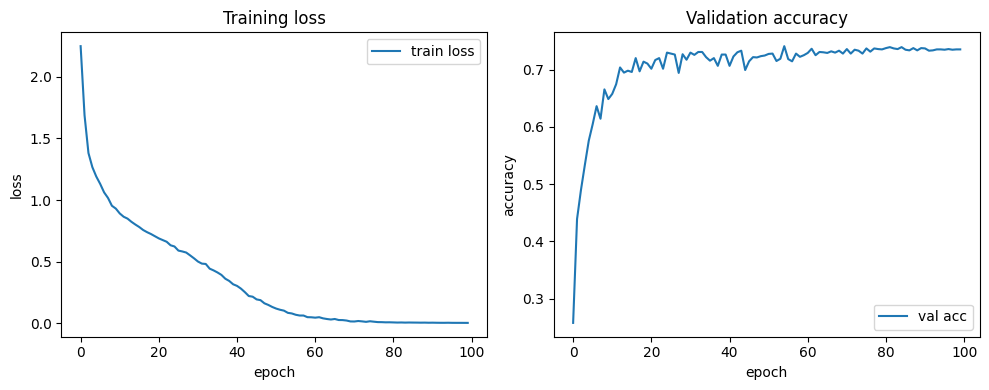

In [51]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(val_accs, label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Validation accuracy'); plt.legend()
plt.tight_layout(); plt.show()


## 8) Reload best checkpoint and evaluate on validation

In [52]:
if best_path.exists():
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    print(f'Loaded best checkpoint from epoch {ckpt.get("epoch")}, val_acc={ckpt.get("acc"):.4f}')

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Eval best [val]'):
        xb = batch['pixel_values'].to(DEVICE)
        yb = batch['label']
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
        pr = logits.argmax(1).cpu()
        y_true += yb.numpy().tolist()
        y_pred += pr.numpy().tolist()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Loaded best checkpoint from epoch 55, val_acc=0.7413


Eval best [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3794604/2812230969.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval best [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

              precision    recall  f1-score   support

           0       0.44      0.36      0.40       108
           1       0.81      0.76      0.78       185
           2       0.90      0.91      0.90       265
           3       0.85      0.89      0.87       203
           4       0.77      0.59      0.67        34
           5       0.71      0.70      0.70       204
           6       0.61      0.66      0.63       183
           7       0.58      0.57      0.57       263
           8       0.83      0.87      0.85       142
           9       0.80      0.84      0.82       187

    accuracy                           0.74      1774
   macro avg       0.73      0.71      0.72      1774
weighted avg       0.74      0.74      0.74      1774



## 9) Confusion matrix

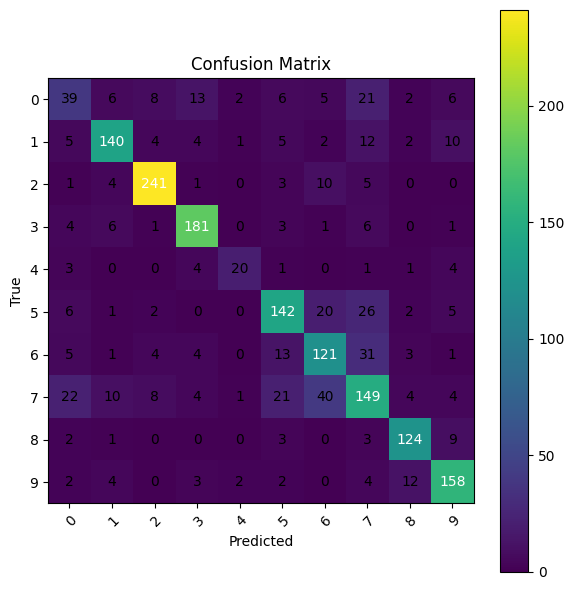

In [53]:
from sklearn.metrics import confusion_matrix
import numpy as np, matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xlabel='Predicted', ylabel='True', title='Confusion Matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')
fig.tight_layout(); plt.show()
